# Assignment 4: Variational Autoencoders - Kai Ponel & Hannan Mahadik 

# Imports

In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks, losses, optimizers, metrics

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Dataset

In [ ]:
ds = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = ds.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.reshape(x_train, newshape=(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)) 
x_test = np.reshape(x_test, newshape=(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1))

In [ ]:
batch_size = 256

dae_train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, x_train))
  .shuffle(1024)
  .batch(batch_size))

dae_test_dataset = (tf.data.Dataset.from_tensor_slices((x_test, x_test))
  .shuffle(1024)
  .batch(batch_size))

# Loss functions - Stolen from Jens' nb

In [ ]:
# a few options for loss functions
# all of these SUM over the image dimensions (height, width, channels)
# -- recall the discussion in the exercise

def squared_loss(y_true, y_pred):
    # this is what we get if assuming a gaussian likelihood and unknown fixed sigma
    batch_shape = tf.shape(y_true)[0]
    y_true = tf.reshape(y_true, [batch_shape, -1])
    y_pred = tf.reshape(y_pred, [batch_shape, -1])
    
    return tf.reduce_mean(tf.reduce_sum((y_true - y_pred)**2, axis=-1))


def logloss(y_true, y_pred):
    # this is what we get if assuming a gaussian likelihood and choosing optimal sigma
    batch_shape = tf.shape(y_true)[0]
    y_true = tf.reshape(y_true, [batch_shape, -1])
    y_pred = tf.reshape(y_pred, [batch_shape, -1])
    
    return tf.reduce_mean(tf.math.log(tf.norm(y_true - y_pred, axis=-1)))


def bernoulli_loss(y_true, y_pred):
    # this is what we get if assuming a bernoulli likelihood
    batch_shape = tf.shape(y_true)[0]
    y_true = tf.reshape(y_true, [batch_shape, -1])
    y_pred = tf.reshape(y_pred, [batch_shape, -1])
    
    xent = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    
    return tf.reduce_mean(tf.reduce_sum(xent, axis=-1))


def continuous_bernoulli_log_normalizer(lam, l_lim=0.49, u_lim=0.51):
    # this is what we get if assuming a continuous bernoulli likelihood.
    # taken from https://github.com/cunningham-lab/cb_and_cc
    cut_lam = tf.where(tf.logical_or(tf.less(lam, l_lim), tf.greater(lam, u_lim)), lam, l_lim * tf.ones_like(lam))
    log_norm = tf.math.log(tf.abs(2.0 * tf.math.atanh(1 - 2.0 * cut_lam))) - tf.math.log(tf.abs(1 - 2.0 * cut_lam))
    taylor = tf.math.log(2.0) + 4.0 / 3.0 * tf.pow(lam - 0.5, 2) + 104.0 / 45.0 * tf.pow(lam - 0.5, 4)
    return tf.where(tf.logical_or(tf.less(lam, l_lim), tf.greater(lam, u_lim)), log_norm, taylor)


def continuous_bernoulli_loss(y_true, y_pred):
    # this is the loss for the continuous bernoulli distribution.
    # it's really just binary cross-entropy plus one more term corresponding to the normalization constant
    batch_shape = tf.shape(y_true)[0]
    y_true = tf.reshape(y_true, [batch_shape, -1])
    y_pred = tf.reshape(y_pred, [batch_shape, -1])
    
    base = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    add = continuous_bernoulli_log_normalizer(tf.clip_by_value(tf.nn.sigmoid(y_pred), 1e-4, 1 - 1e-4))
    
    return tf.reduce_mean(tf.reduce_sum(base - add, axis=-1))


def continuous_bernoulli_expected_value(lam, l_lim=0.49, u_lim=0.51):
    # our networks output distribution parameters, but we want the expected value.
    # for gaussian and bernoulli distributions, the expected value is just equal to (one of) the
    # distribution parameter(s).
    # if using continuous bernoulli, the expected value is a bit more complicated
    cut_lam = tf.where(tf.logical_or(tf.less(lam, l_lim), tf.greater(lam, u_lim)), lam, l_lim * tf.ones_like(lam))
    expected = cut_lam / (2*cut_lam - 1) + 1 / (2*tf.math.atanh(1 - 2*cut_lam))
    return tf.where(tf.logical_or(tf.less(lam, l_lim), tf.greater(lam, u_lim)), expected, 0.5*tf.ones_like(expected))

# Hyperparameters

In [ ]:
encoding_dim = 784
num_hidden_units = 10
num_output_units = 10

img_dim_x = 28
img_dim_y = 28
img_dim_z = 1

# Encoder

In [ ]:
# Encoder
encoder_input = tf.keras.Input((img_dim_x, img_dim_y, img_dim_z))      

conv1 = tf.keras.layers.Conv2D(img_dim_x, img_dim_z, activation = 'relu', padding = 'same')(encoder_input)     
pool1 = tf.keras.layers.MaxPool2D()(conv1)                                                  
conv2 = tf.keras.layers.Conv2D(64, img_dim_z, activation = 'relu', padding = 'same')(pool1)            
pool2 = tf.keras.layers.MaxPool2D()(conv2)                                                   
conv3 = tf.keras.layers.Conv2D(128, img_dim_z, activation = 'relu', padding = 'same')(pool2)           
pool3 = tf.keras.layers.MaxPool2D()(conv3) 

flattened = tf.keras.layers.Flatten()(pool3)

encoder_output = tf.keras.layers.Dense(encoding_dim, activation = 'relu')(flattened)

encoder = tf.keras.Model(encoder_input, encoder_output)

# Decoder

In [ ]:
# Decoder
decoder_input = tf.keras.Input((encoding_dim,))
dense = tf.keras.layers.Dense(4 * 4 * 128, activation = 'relu')(decoder_input)
reshaped = tf.keras.layers.Reshape((4, 4, 128))(dense)                                       
deconv1 = tf.keras.layers.Conv2DTranspose(64, 10, activation='relu')(reshaped)                
deconv2 = tf.keras.layers.Conv2DTranspose(img_dim_y, 8, activation='relu')(deconv1)                
decoder_output = tf.keras.layers.Conv2DTranspose(img_dim_z, 9, activation='sigmoid')(deconv2)             
decoder = tf.keras.Model(decoder_input, decoder_output)

# Compile

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [ ]:
# Autoencoder
autoencoder = tf.keras.Model(encoder_input, decoder(encoder_output))
autoencoder.compile(optimizer = optimizer, loss = loss_fn)

In [ ]:
autoencoder.fit(dae_train_dataset, epochs = 30, validation_data = dae_test_dataset)

Epoch 1/30
235/235 [==============================] - 20s 25ms/step - loss: 0.2501 - val_loss: 0.1965
Epoch 2/30
235/235 [==============================] - 5s 22ms/step - loss: 0.1817 - val_loss: 0.1714
Epoch 3/30
235/235 [==============================] - 5s 22ms/step - loss: 0.1667 - val_loss: 0.1639
Epoch 4/30
235/235 [==============================] - 5s 22ms/step - loss: 0.1590 - val_loss: 0.1557
Epoch 5/30
235/235 [==============================] - 5s 22ms/step - loss: 0.1533 - val_loss: 0.1505
Epoch 6/30
235/235 [==============================] - 5s 22ms/step - loss: 0.1487 - val_loss: 0.1476
Epoch 7/30
235/235 [==============================] - 5s 23ms/step - loss: 0.1452 - val_loss: 0.1446
Epoch 8/30
235/235 [==============================] - 5s 22ms/step - loss: 0.1419 - val_loss: 0.1414
Epoch 9/30
235/235 [==============================] - 5s 22ms/step - loss: 0.1391 - val_loss: 0.1404
Epoch 10/30
235/235 [==============================] - 5s 22ms/step - loss: 0.1367 - val_l

1/1 [==============================] - 0s 21ms/step


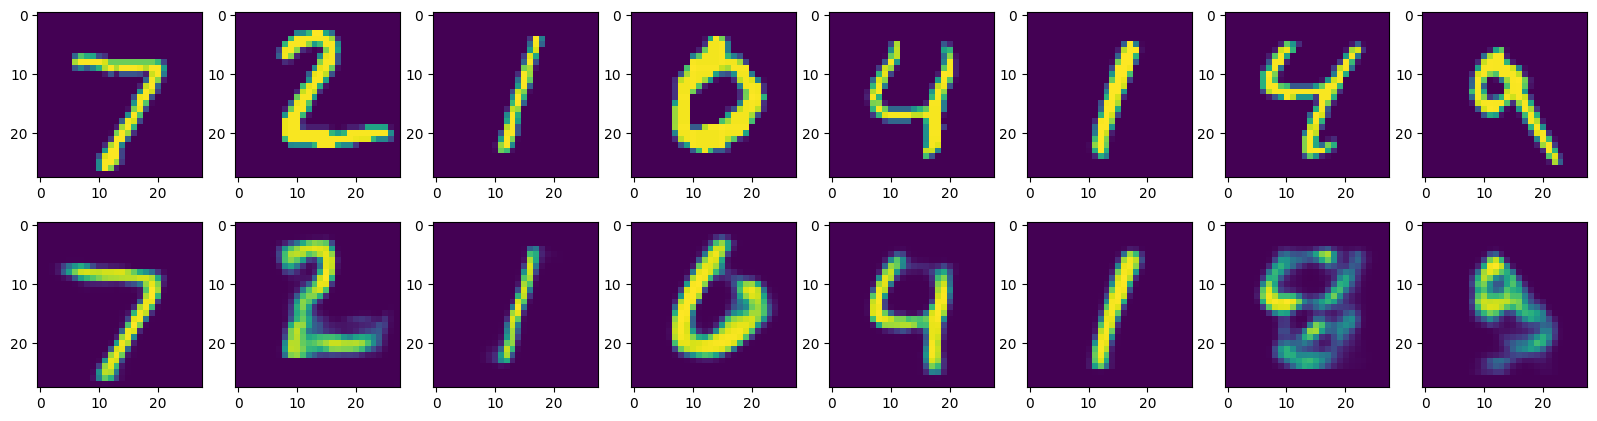

In [ ]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  pred = autoencoder.predict(x_test[i].reshape((1,28,28,1)))
  imshow(x_test[i])

  subplot(2, 8, i+8+1)
  imshow(pred.reshape((28, 28, 1)))

# VAE

## Definition Stuff

### Reparameterization Trick

*The Following code is based on this articel*: https://blog.paperspace.com/how-to-build-variational-autoencoder-keras/

*We tried implementing the VAE using a Custom Keras model implementation (see code in the extra block) however we kept running into issues. After too much time spent on that we decided to go with an easier implementation and focus on the "Experiment" section of the assignment. The definition of the encoder and decoder are easy to grasp and we decided to stick with their Model architecture/parameters because they seemed to work well. This week time was very limited.*

In [ ]:
def reparametrization_trick(z_mu_log_var):
  z_mean, z_log_var = z_mu_log_var
  batch = tf.shape(z_mean)[0]
  dim = tf.shape(z_mean)[1]
  epsilon = tf.random.normal((batch, dim), 0, 1)

  
  return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder


In [ ]:
encoder_input = tf.keras.Input((img_dim_x, img_dim_y, img_dim_z))    

# Encoder
x = tf.keras.layers.Input(shape=(img_dim_x, img_dim_y, img_dim_z), name="encoder_input")

encoder_conv_layer1 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tf.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tf.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tf.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tf.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tf.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tf.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tf.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tf.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tf.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tf.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tf.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tf.keras.layers.Flatten()(encoder_activ_layer5)

encoder_mu = tf.keras.layers.Dense(units=num_hidden_units, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tf.keras.layers.Dense(units=num_hidden_units, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tf.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tf.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tf.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = tf.keras.models.Model(x, encoder_output, name="encoder_model")

### Decoder

In [ ]:
decoder_input = tf.keras.layers.Input(shape=(num_hidden_units), name="decoder_input")
decoder_dense_layer1 = tf.keras.layers.Dense(units=np.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tf.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)

decoder_conv_tran_layer1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tf.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tf.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tf.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tf.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tf.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tf.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tf.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

decoder = tf.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

## Approach without using a Custom Model-Class

In [ ]:
def loss_func(encoder_mu, encoder_log_variance, beta=1.0):
    # Define reconstruction loss
    def vae_reconstruction_loss(y_true, y_predict):
        # Calculate sum squared error
        reconstruction_loss = tf.keras.backend.sum(tf.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss

    # Define KL divergence loss
    def vae_kl_loss(encoder_mu, encoder_log_variance):
        # Calculate closed-form solution for KL divergence between two multivariate Gaussians

        # Closed form for gaussians: KLD == -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return beta * kl_loss

    # Define metric for KL divergence loss
    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    # Define overall VAE loss as sum of reconstruction and KL divergence losses
    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [ ]:
vae_input = layers.Input(shape=(img_dim_x, img_dim_y, img_dim_z), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tf.keras.models.Model(vae_input, vae_decoder_output, name="VAE")

vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss=loss_func(encoder_mu, encoder_log_variance, beta=1.0), jit_compile=True)

In [ ]:
vae.fit(x_train, x_train, epochs=10, batch_size=32, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 34s 7ms/step - loss: 26.6276 - val_loss: 17.8253
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 16.7906 - val_loss: 16.3062
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 15.1541 - val_loss: 14.5332
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 14.2356 - val_loss: 13.8024
Epoch 5/10
1875/1875 [==============================] - 14s 7ms/step - loss: 13.6644 - val_loss: 13.4776
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 13.2260 - val_loss: 12.7922
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 12.9038 - val_loss: 13.3746
Epoch 8/10
1875/1875 [==============================] - 12s 6ms/step - loss: 12.6111 - val_loss: 12.5364
Epoch 9/10
1875/1875 [==============================] - 11s 6ms/step - loss: 12.3945 - val_loss: 12.4653
Epoch 10/10
1875/1875 [==============================] 

## Experimental section

### Print some reconstructions

1/1 [==============================] - 0s 21ms/step


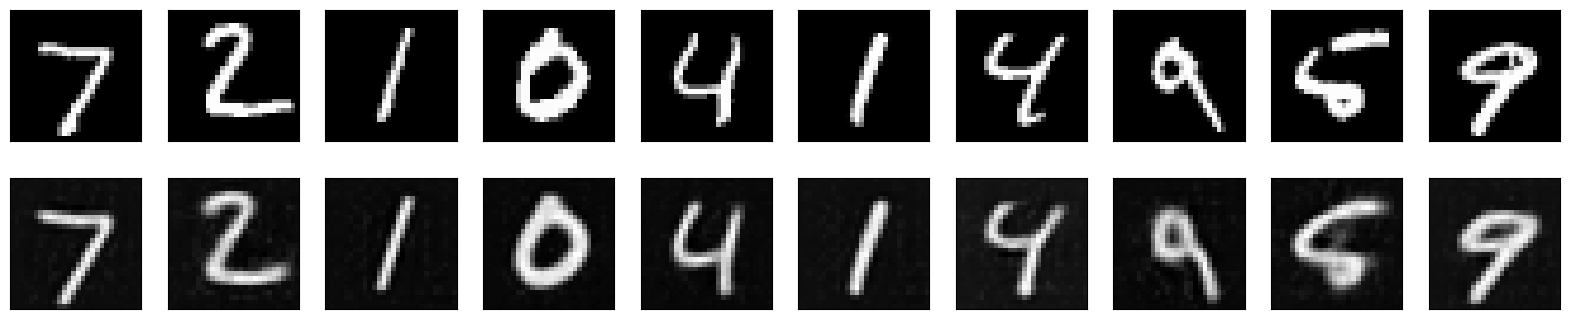

In [ ]:
### Print some Samples!
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(img_dim_x, img_dim_y))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    reconstructed_img = vae.predict(x_test[i].reshape(1,img_dim_x,img_dim_y,img_dim_z))
    plt.imshow(reconstructed_img.reshape(img_dim_x, img_dim_y))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Generate some random samples with N(0,1)
(Expected results ^^)

1/1 [==============================] - 0s 273ms/step


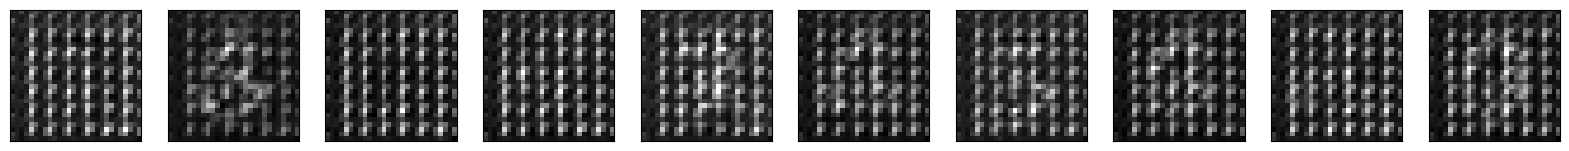

In [ ]:
# Print some random (N(0,1)) Samples
n = 10  # number of samples to generate
latent_dim = encoder.layers[-1].output_shape[1] # dimensionality of the latent space

# Sample from the latent space
z_sample = np.random.normal(size=(n, latent_dim))

# Use the decoder to generate new images
generated_images = decoder.predict(z_sample)

# Plot the generated images
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(generated_images[i].reshape(img_dim_x, img_dim_y))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Get the average Mu and log_var values based on the class label and sample based on that

In [ ]:
# Sort dataset
from collections import defaultdict

# Create a dictionary to store the images for each class
images_by_class = defaultdict(list)

# Iterate over x_test and y_test and sort the entries
for image, label in zip(x_test, y_test):
    images_by_class[label].append(image)

33/33 [==============================] - 0s 4ms/step


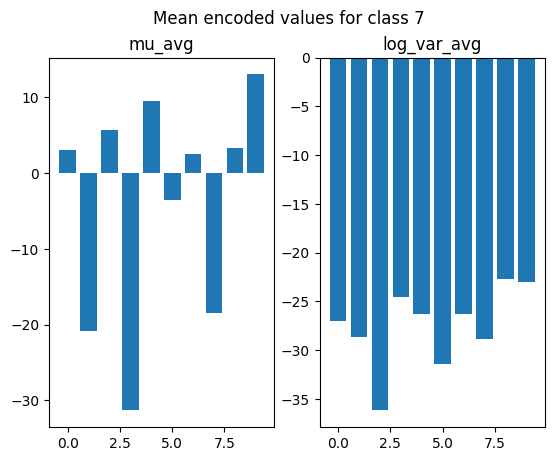

33/33 [==============================] - 0s 2ms/step


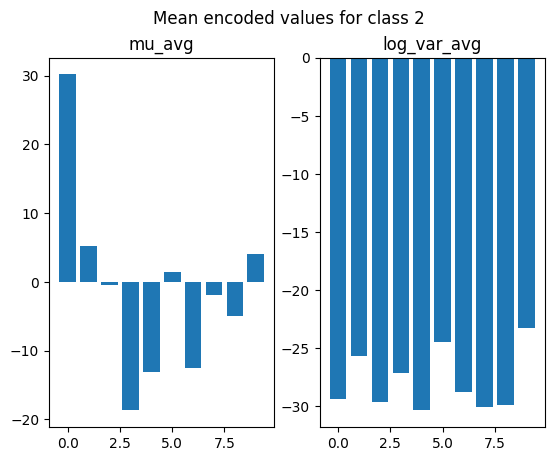

36/36 [==============================] - 0s 2ms/step


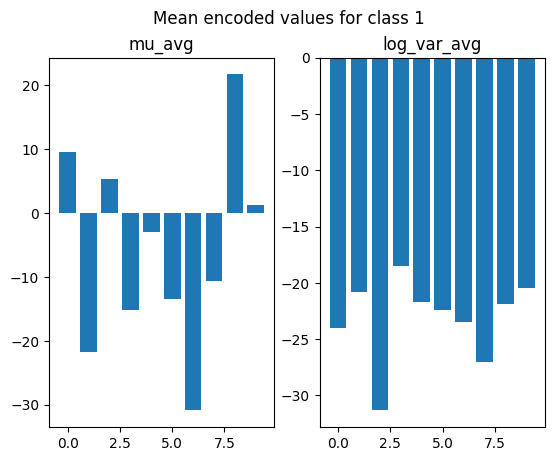

31/31 [==============================] - 0s 2ms/step


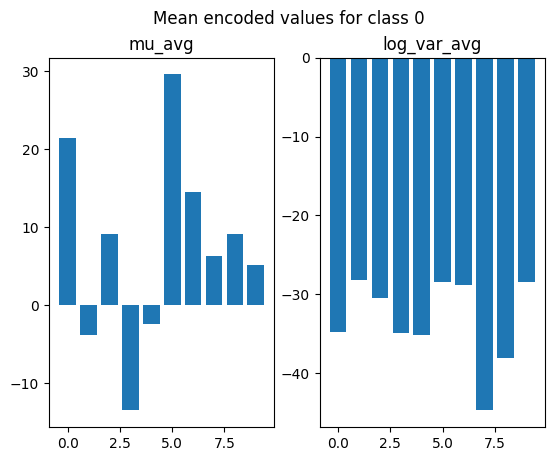

31/31 [==============================] - 0s 2ms/step


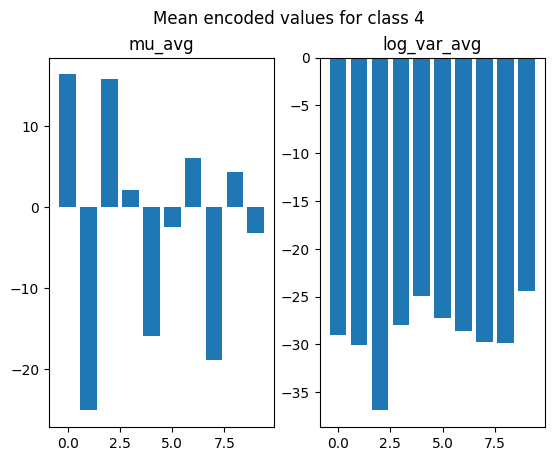

32/32 [==============================] - 0s 3ms/step


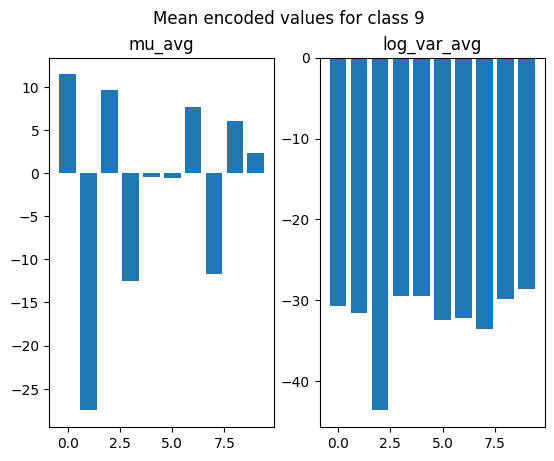

28/28 [==============================] - 0s 2ms/step


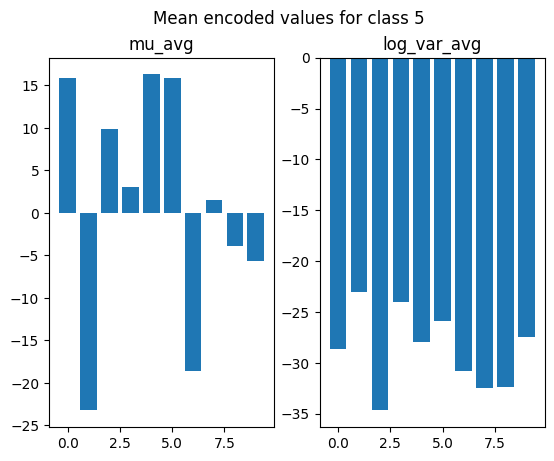

30/30 [==============================] - 0s 3ms/step


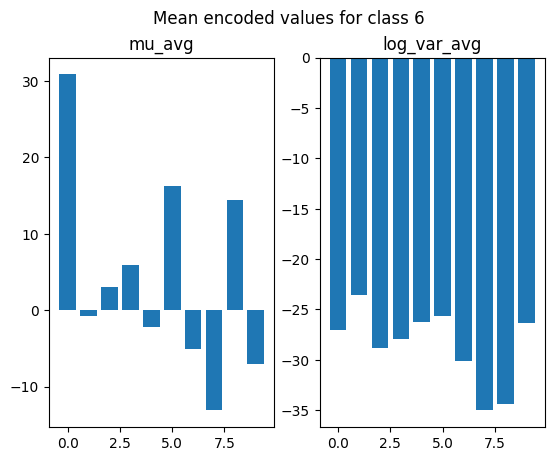

32/32 [==============================] - 0s 3ms/step


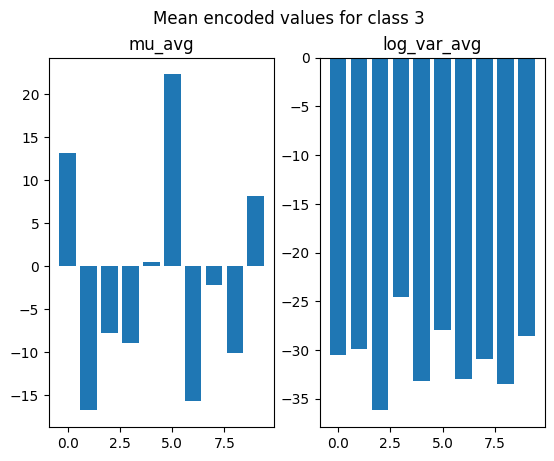

31/31 [==============================] - 0s 2ms/step


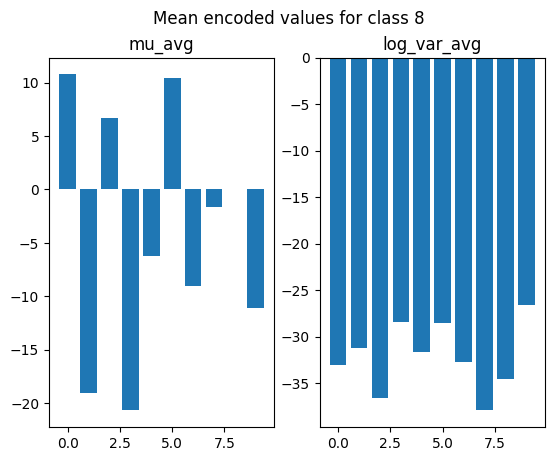

In [ ]:
MEANS = list()

# Iterate over the classes in the dictionary
for label, images in images_by_class.items():
    # Convert the list of images to a numpy array
    images = np.array(images)
    
    # Feed the images to the encoder
    encoded_images = encoder.predict(images)

    mu, log_var = encoder_mu_log_variance_model.predict(images)
    
    # Compute the mean of the encoded values for each output index
    mu_avg = np.mean(mu, axis=0)
    log_var_avg = np.mean(log_var, axis=0)

    MEANS.append((mu_avg, log_var_avg))
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f"Mean encoded values for class {label}")

    # Create a bar chart of the means in the first subplot
    ax1.bar(range(num_hidden_units), mu_avg)
    ax1.set_title("mu_avg")

    # Create a bar chart of the log_var in the second subplot
    ax2.bar(range(num_hidden_units), log_var_avg)
    ax2.set_title("log_var_avg")

    plt.show()

1/1 [==============================] - 0s 20ms/step


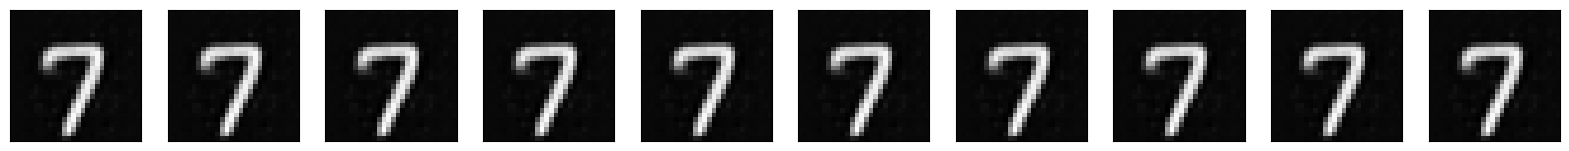

In [ ]:
# Print random samples based on the mu and log_var values from the encoder
n = 10 # number of samples to generate
latent_dim = encoder.layers[-1].output_shape[1] # dimensionality of the latent space

# Get mu and log_var values from the encoder
mu, log_var = MEANS[0]

# Sample from the latent space using mu and log_var values
epsilon = np.random.normal(size=(n, latent_dim))
z_sample = mu + np.exp(log_var / 2) * epsilon

# Use the decoder to generate new images
generated_images = decoder.predict(z_sample)

# Plot the generated images
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(generated_images[i].reshape(img_dim_x, img_dim_y))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# # Use the decoder to generate new images
# generated_images = decoder.predict(np.array(MEANS))

# # Plot the generated images
# plt.figure(figsize=(20, 4))
# for i in range(n):
#     ax = plt.subplot(1, n, i + 1)
#     plt.imshow(generated_images[i].reshape(img_dim_x, img_dim_y))
#     plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()

## Extra: Old (Custom Class) VAE Model


In [ ]:
class VAE(tf.keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    # self.encoding_dim = encoding_dim
    self.encoder = encoder
    self.decoder = decoder

    self.total_loss_tracker = metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
      return [
          self.total_loss_tracker,
          self.reconstruction_loss_tracker,
          self.kl_loss_tracker,
      ]


  def call(self, input):
    z, z_mean, z_log_var = self.encoder(input)
    reconstructed_input = self.decoder(z)

    return reconstructed_input, z_mean, z_log_var

  def train_step(self, data):
        
        with tf.GradientTape() as tape:
            tf.print(data)
            z_mean, z_log_var, reconstruction = self(data)
            
            reconstruction_loss = tf.reduce_mean(continuous_bernoulli_loss(data, reconstruction))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + tf.math.log(z_log_var ** 2) - z_mean ** 2 - z_log_var ** 2), axis=1))

            total_loss = -reconstruction_loss - BETA * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

  def test_step(self, data):
      if isinstance(data, tuple):
          data = data[0]

      z_mean, z_log_var, reconstruction = self(data)

      reconstruction_loss = tf.reduce_mean(continuous_bernoulli_loss(data, reconstruction))
      kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + tf.math.log(z_log_var ** 2) - z_mean ** 2 - z_log_var ** 2), axis=1))

      total_loss = -reconstruction_loss - BETA * kl_loss

      return {
          "loss": total_loss,
          "reconstruction_loss": reconstruction_loss,
          "kl_loss": kl_loss,
      }

In [ ]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)
optimizer = optimizers.Adam()
vae.compile(optimizer=optimizer)
BETA = 1

In [ ]:
print(z_mean.shape)
print(z_log_var.shape)

In [ ]:
vae.fit(
    x_train,
    epochs=10,
    batch_size=32,
    shuffle=True,
    validation_data=(x_test, x_test)
)